# setup

In [1]:
import numpy as np
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import sewar.full_ref as sewar

from tqdm import tqdm
from pesq import pesq
from pesq import PesqError
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from pystoi.stoi import stoi
from scipy.signal import lfilter, hamming
from scipy.linalg import solve_toeplitz, toeplitz

# data

In [2]:
input_file = 'model_outputs/lusiadas_mol.wavernn/1000k_steps_1_gen_batched_target11000_overlap550.wav'
reference_file = 'model_outputs/lusiadas_mol.wavernn/1000k_steps_1_target.wav'
ref_files = pd.read_csv('ref_test_set.txt', header = None)
gen_files = pd.read_csv('gen_test_set.txt', header = None)

In [3]:
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    # print(ref_file, gen_file)

279it [00:00, 1789.15it/s]


# utils

In [4]:
def load_audio(file_path):
    data, rate = sf.read(file_path)
    return data, rate

In [5]:
def add_noise(audio_file, noise_level):
    audio, _ = load_audio(audio_file)
    amplitude = max(audio) * noise_level
    noise = np.random.normal(0, amplitude, audio.shape)
    return audio + noise

# pesq

In [6]:
def calculate_pesq(reference_file, degraded_file):
    try:
        ref, rate_ref = load_audio(reference_file)
        deg, rate = load_audio(degraded_file)
        assert rate == rate_ref

        # if len(ref) > len(deg):
        #     ref = ref[:len(deg)]
        # else:
        #     deg = deg[:len(ref)]

        pesq_score = pesq(rate, ref, deg, 'nb')
        
        return pesq_score
    except PesqError as e:
        print(f"PESQ Error: {e}")
        return None

In [7]:
def calculate_pesq_solo(reference_file, noise_level):
    try:
        ref, rate = load_audio(reference_file)

        amplitude = max(ref) * noise_level
        noise = np.random.normal(0, amplitude, ref.shape)
        deg = ref + noise

        pesq_score = pesq(rate, ref, deg, 'nb')
        
        return pesq_score
    except PesqError as e:
        print(f"PESQ Error: {e}")
        return None

In [8]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    pesq_score = calculate_pesq(ref_file, gen_file)
    log.append(pesq_score)

279it [01:28,  3.17it/s]


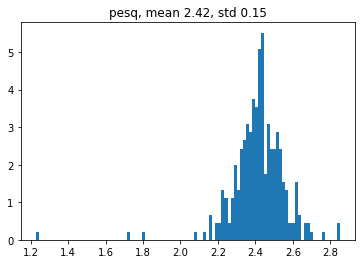

In [14]:
mu = np.mean(log)

plt.hist(log, bins = 100, density = True);
plt.title('pesq, mean {:.2f}, std {:.2f}'.format(np.mean(log), np.std(log)));

In [20]:
loglog = []
for noise in tqdm(np.linspace(1e-3, 1e-1, 15)):
    log = []
    for idx, row in (ref_files.iterrows()):
        ref_file = row.values[0]
        pesq_score = calculate_pesq_solo(ref_file, noise)
        log.append(pesq_score)
    loglog.append(np.mean(log))

100%|██████████| 15/15 [16:19<00:00, 65.27s/it]


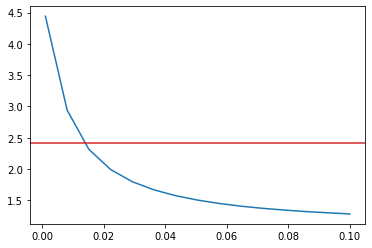

In [25]:
plt.plot(np.linspace(1e-3, 1e-1, 15), loglog);
plt.axhline(y = mu, color = 'tab:red');

# snr

In [26]:
def calculate_snr(reference_file, degraded_file):
    ref, rate_ref = load_audio(reference_file)
    deg, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    if len(ref) > len(deg):
        ref = ref[:len(deg)]
    else:
        deg = deg[:len(ref)]

    noise = ref - deg
    signal_power = np.mean(ref ** 2)
    noise_power = np.mean(noise ** 2)

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [27]:
def calculate_snr_solo(reference_file, noise_level):
    ref, rate_ref = load_audio(reference_file)
    amplitude = max(ref) * noise_level
    deg = ref + np.random.normal(0, amplitude, ref.shape)
    
    noise = ref - deg
    signal_power = np.mean(ref ** 2)
    noise_power = np.mean(noise ** 2)

    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [34]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    snr_score = calculate_snr(ref_file, gen_file)
    log.append(snr_score)

279it [00:00, 587.72it/s]


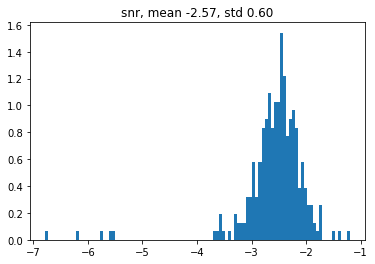

In [35]:
mu = np.mean(log)

plt.hist(log, bins = 100, density = True);
plt.title('snr, mean {:.2f}, std {:.2f}'.format(np.mean(log), np.std(log)));

In [32]:
loglog = []
for noise in tqdm(np.linspace(1e-3, 5e-1, 15)):
    log = []
    for idx, row in (ref_files.iterrows()):
        ref_file = row.values[0]
        pesq_score = calculate_snr_solo(ref_file, noise)
        log.append(pesq_score)
    loglog.append(np.mean(log))

100%|██████████| 15/15 [01:37<00:00,  6.52s/it]


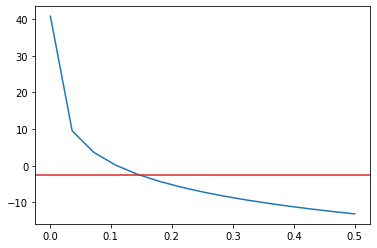

In [33]:
plt.plot(np.linspace(1e-3, 5e-1, 15), loglog);
plt.axhline(y = mu, color = 'tab:red');

# mfcc dtw

In [36]:
def calculate_mfcc(audio, rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=rate, n_mfcc=n_mfcc)
    return mfccs.T

def compare_mfcc(reference_file, degraded_file, n_mfcc=13):
    ref_audio, rate_ref = load_audio(reference_file)
    deg_audio, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    ref_mfcc = calculate_mfcc(ref_audio, rate_ref, n_mfcc = n_mfcc)
    deg_mfcc = calculate_mfcc(deg_audio, rate_deg, n_mfcc = n_mfcc)

    distance, path = fastdtw(ref_mfcc, deg_mfcc, dist=euclidean)
    return distance

In [37]:
def compare_mfcc_solo(reference_file, noise_level, n_mfcc=13):
    ref_audio, rate_ref = load_audio(reference_file)
    amplitude = max(ref_audio) * noise_level
    deg_audio = ref_audio + np.random.normal(0, amplitude, ref_audio.shape)

    ref_mfcc = calculate_mfcc(ref_audio, rate_ref, n_mfcc = n_mfcc)
    deg_mfcc = calculate_mfcc(deg_audio, rate_ref, n_mfcc = n_mfcc)

    distance, path = fastdtw(ref_mfcc, deg_mfcc, dist=euclidean)
    return distance

In [38]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    mfccdtw_score = compare_mfcc(ref_file, gen_file)
    log.append(mfccdtw_score)

279it [00:29,  9.33it/s]


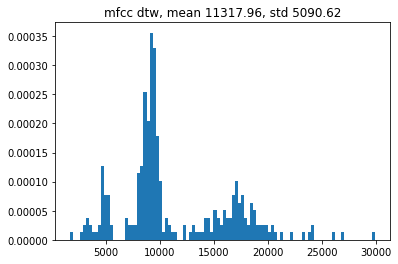

In [39]:
mu = np.mean(log)

plt.hist(log, bins = 100, density = True);
plt.title('mfcc dtw, mean {:.2f}, std {:.2f}'.format(np.mean(log), np.std(log)));

In [42]:
loglog = []
ns = np.linspace(1e-3, 1e-2, 15)
for noise in tqdm(ns):
    log = []
    for idx, row in (ref_files.iterrows()):
        ref_file = row.values[0]
        pesq_score = compare_mfcc_solo(ref_file, noise)
        log.append(pesq_score)
    loglog.append(np.mean(log))

100%|██████████| 15/15 [08:51<00:00, 35.43s/it]


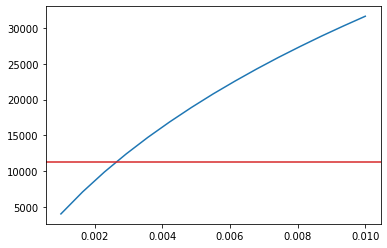

In [43]:
plt.plot(ns, loglog);
plt.axhline(y = mu, color = 'tab:red');

# stoi

In [44]:
def calculate_stoi(reference_file, degraded_file):
    ref, rate_ref = load_audio(reference_file)
    deg, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    if len(ref) > len(deg):
        ref = ref[:len(deg)]
    else:
        deg = deg[:len(ref)]

    stoi_score = stoi(ref, deg, rate_ref, extended=False)
    return stoi_score

In [45]:
def calculate_stoi_solo(reference_file, noise_level):
    ref, rate_ref = load_audio(reference_file)
    amplitude = max(ref) * noise_level
    deg = ref + np.random.normal(0, amplitude, ref.shape)

    stoi_score = stoi(ref, deg, rate_ref, extended=False)
    return stoi_score

In [46]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    stoi_score = calculate_stoi(ref_file, gen_file)
    log.append(stoi_score)

279it [00:24, 11.59it/s]


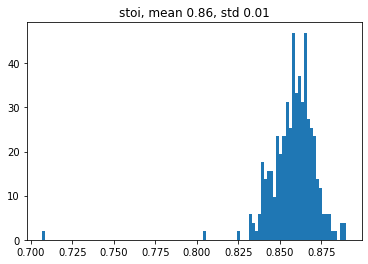

In [47]:
mu = np.mean(log)

plt.hist(log, bins = 100, density = True);
plt.title('stoi, mean {:.2f}, std {:.2f}'.format(np.mean(log), np.std(log)));

In [49]:
loglog = []
ns = np.linspace(1e-2, 5e-2, 15)
for noise in tqdm(ns):
    log = []
    for idx, row in (ref_files.iterrows()):
        ref_file = row.values[0]
        pesq_score = calculate_stoi_solo(ref_file, noise)
        log.append(pesq_score)
    loglog.append(np.mean(log))

100%|██████████| 15/15 [07:07<00:00, 28.52s/it]


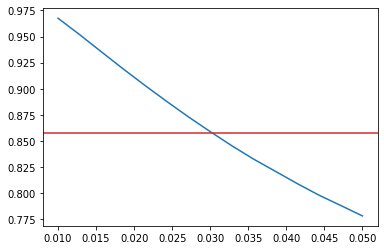

In [50]:
plt.plot(ns, loglog);
plt.axhline(y = mu, color = 'tab:red');

# lsd

In [51]:
def log_spectral_distance(ref_audio, deg_audio, sr):
    ref_spec = np.log(np.abs(librosa.stft(ref_audio)) + 1e-10)
    deg_spec = np.log(np.abs(librosa.stft(deg_audio)) + 1e-10)

    lsd = np.mean(np.sqrt(np.mean((ref_spec - deg_spec) ** 2, axis=0)))
    return lsd

def calculate_lsd(reference_file, degraded_file):
    ref, rate_ref = load_audio(reference_file)
    deg, rate_deg = load_audio(degraded_file)

    if rate_ref != rate_deg:
        raise ValueError("The reference and degraded files must have the same sampling rate")

    min_len = min(len(ref), len(deg))
    ref_audio = ref[:min_len]
    deg_audio = deg[:min_len]

    lsd = log_spectral_distance(ref_audio, deg_audio, rate_ref)
    return lsd

In [52]:
def calculate_lsd_solo(reference_file, noise_level):
    ref, rate_ref = load_audio(reference_file)
    amplitude = max(ref) * noise_level
    deg = ref + np.random.normal(0, amplitude, ref.shape)

    min_len = min(len(ref), len(deg))
    ref_audio = ref[:min_len]
    deg_audio = deg[:min_len]

    lsd = log_spectral_distance(ref_audio, deg_audio, rate_ref)
    return lsd

In [53]:
log = []
for idx, row in tqdm(ref_files.iterrows()):
    ref_file = row.values[0]
    gen_file = gen_files[0][idx]

    assert ref_file.split('/')[-1].split('_')[2] == gen_file.split('/')[-1].split('_')[2]
    lsd_score = calculate_lsd(ref_file, gen_file)
    log.append(lsd_score)

279it [00:06, 44.95it/s]


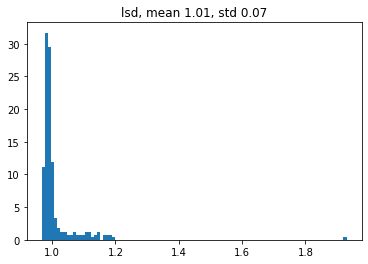

In [54]:
mu = np.mean(log)

plt.hist(log, bins = 100, density = True);
plt.title('lsd, mean {:.2f}, std {:.2f}'.format(np.mean(log), np.std(log)));

In [55]:
loglog = []
ns = np.linspace(1e-3, 5e-3, 15)
for noise in tqdm(ns):
    log = []
    for idx, row in (ref_files.iterrows()):
        ref_file = row.values[0]
        pesq_score = calculate_lsd_solo(ref_file, noise)
        log.append(pesq_score)
    loglog.append(np.mean(log))

100%|██████████| 15/15 [03:01<00:00, 12.08s/it]


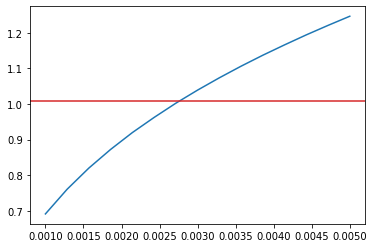

In [56]:
plt.plot(ns, loglog);
plt.axhline(y = mu, color = 'tab:red');